Size of dataset : 4056
Most recent data point at : 2018-03-23 : [535.7]
Oldest data point at : 2001-12-31 : [8.45]


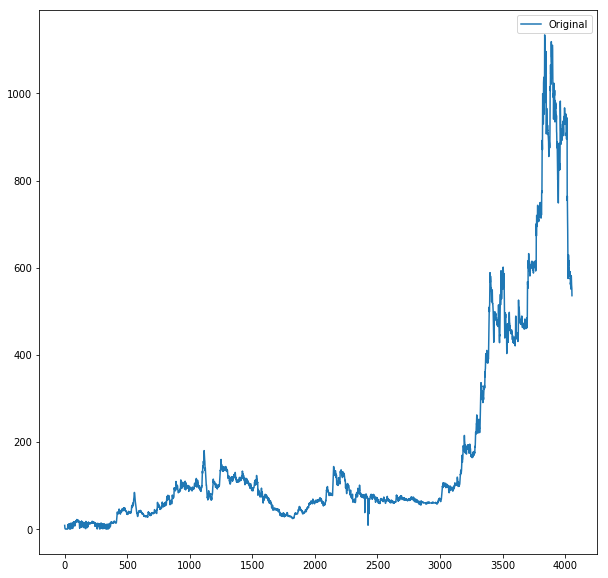

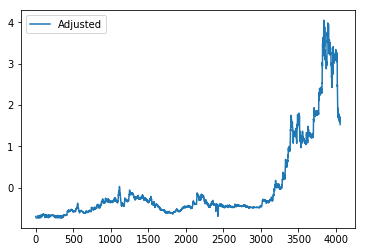

In [35]:
# -------------------- Imports -------------------- #
import keras, pandas as pd, sys, numpy as np, math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 


plt.figure(figsize=(10, 10))

# -------------------- Globals -------------------- #
input_file = '../data/BSE:CORALAB.csv'
dataset = None
look_back = 365

verbosity = True
np.random.seed(66)


# -------------------- Data -------------------- #
def invert_differencing(inverter, dataset):
    ret = [inverter]
    for i in range(len(dataset)):
        inverter += dataset[i]
        ret.append(inverter)
    return ret

def data_with_look_back(dataset):
    '''Returns x with look_back samples at time t and y with the sample at t+1 '''

    if len(dataset) < look_back:
        raise Exception("Dataset not large enough for given look back!")

    x, y = list(), list()
    for i in range(len(dataset) - look_back):
        x.append(dataset[i:look_back+i])
        y.append(dataset[look_back+i])
    
    return np.array(x), np.array(y)


# Get data
df = pd.read_csv(input_file, usecols=['timestamp', 'close'])
dataset = df['close'].astype('float32')
dataset = dataset[::-1]
dataset = dataset.values.reshape((-1,1))

if verbosity:
    print("Size of dataset :", len(dataset))
    print("Most recent data point at :", df['timestamp'][0], ":", dataset[len(dataset) - 1])
    print("Oldest data point at :", df['timestamp'][len(df['timestamp']) - 1], ":", dataset[0])

for i in range(len(dataset)):       # replace missing values with mean of prev and next
    if dataset[i] == 0:
        dataset[i] = np.mean([dataset[i-1], dataset[i+1]])

plt.plot(dataset, label='Original')
plt.legend()
plt.show()

# Normalize data
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

plt.plot(dataset, label='Adjusted')
plt.legend()
plt.show()

In [36]:
train_x, train_y = data_with_look_back(dataset)
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))

verbose = 0

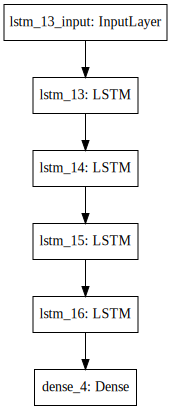

In [37]:
# -------------------- Model -------------------- #
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(10, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(5, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=100, batch_size=30, verbose=verbose)

trainPredict = model.predict(train_x)

# -------------------- Plot Model -------------------- #

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [38]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
train_y = scaler.inverse_transform(train_y)

# calculate average error
trainScore = np.mean([math.fabs(x - y) for x, y in zip(train_y, trainPredict)])
print('Average Error in predictions: %.2f ' % (trainScore))

# calculate RMSE
trainScore = math.sqrt(np.mean([math.fabs(x - y)**2 for x, y in zip(train_y, trainPredict)]))
print('Average RMSE in predictions: %.2f ' % (trainScore))

Average Error in predictions: 6.89 
Average RMSE in predictions: 14.35 


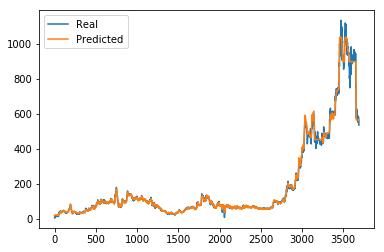

In [39]:
# Predicted Vs Original

plt.plot(train_y, label='Real')
plt.plot(trainPredict, label='Predicted')
plt.legend()
plt.show()

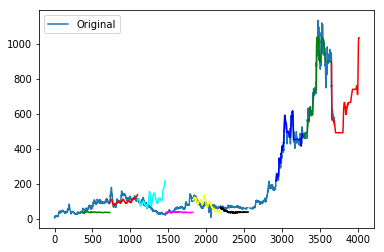

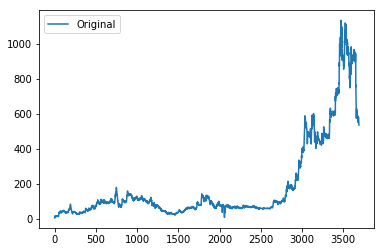

In [40]:
# Print direction of growth - take one batchSize, predict the next year's values
colors = ['green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 'blue']
c = 0
batchSize = 365
end = False
plt.plot(train_y, label='Original')
orig = scaler.transform(train_y)
orig.reshape(orig.shape[0])
for i in range(0, len(train_y)+1, batchSize):
    o = orig[i:i+look_back]
    p = list()
    for j in range(batchSize):
        try:
            p.append(model.predict(o.reshape((1, 1, look_back)))[0])
        except:
            end = True
            break
        o = list(o[1:])
        o.append(p[-1])
        o = np.array(o)
    if end:
        break
    p = scaler.inverse_transform(p)
    plt.plot(range(i+batchSize, i+batchSize+len(p)), p, colors[c])
    c = (c + 1) % len(colors)

orig = scaler.inverse_transform(orig)

plt.legend()
plt.show()

plt.plot(train_y, label='Original')
plt.legend()
plt.show()

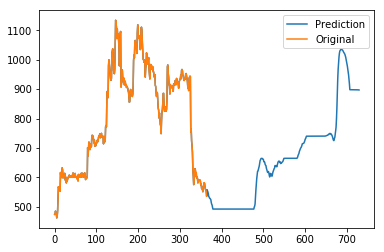

In [41]:
import copy
orig = scaler.transform(train_y)
o = orig[-365:]
p = list(o[:])
for i in range(365):
    p.append(model.predict(o.reshape((1, 1, look_back)))[0])
    o = list(o[1:])
    o.append(p[-1])
    o = np.array(o)
p = scaler.inverse_transform(p)
plt.plot(range(len(p)), p, label='Prediction')

o = scaler.inverse_transform(orig[-365:])
plt.plot(o, label='Original')
plt.legend()
plt.show()

In [42]:
in_a_month = p[364 + 30]
in_3_months = (p[364 + 120])
in_a_year = (p[-1])

print(in_a_month)
print(in_3_months)
print(in_a_year)

[492.06793]
[596.0542]
[897.0001]


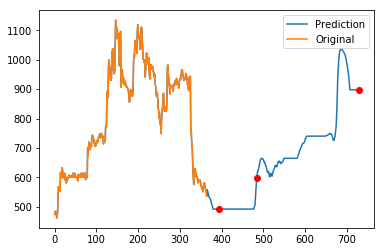

In [43]:
plt.plot(p, label='Prediction')
plt.plot(o, label='Original')
plt.legend()
plt.plot(364+30, in_a_month, 'ro')
plt.plot(364+120, in_3_months, 'ro')
plt.plot(364+365, in_a_year, 'ro')
plt.savefig('next' + input_file.split('/')[-1].split('.')[0] + '.png', format='png')
plt.show()

In [44]:
# Printing all predictions
for i in range(365, len(p)):
    print('+' + str(i-364), '\t', p[i])

+1 	 [557.767]
+2 	 [553.75305]
+3 	 [550.2428]
+4 	 [544.4164]
+5 	 [535.1596]
+6 	 [532.9311]
+7 	 [529.1782]
+8 	 [528.4145]
+9 	 [526.3938]
+10 	 [524.0764]
+11 	 [515.04236]
+12 	 [508.93445]
+13 	 [505.72702]
+14 	 [499.69296]
+15 	 [492.06793]
+16 	 [492.06793]
+17 	 [492.06793]
+18 	 [492.06793]
+19 	 [492.06793]
+20 	 [492.06793]
+21 	 [492.06793]
+22 	 [492.06793]
+23 	 [492.06793]
+24 	 [492.06793]
+25 	 [492.06793]
+26 	 [492.06793]
+27 	 [492.06793]
+28 	 [492.06793]
+29 	 [492.06793]
+30 	 [492.06793]
+31 	 [492.06793]
+32 	 [492.06793]
+33 	 [492.06793]
+34 	 [492.06793]
+35 	 [492.06793]
+36 	 [492.06793]
+37 	 [492.06793]
+38 	 [492.06793]
+39 	 [492.06793]
+40 	 [492.06793]
+41 	 [492.06793]
+42 	 [492.06793]
+43 	 [492.06793]
+44 	 [492.06793]
+45 	 [492.06793]
+46 	 [492.06793]
+47 	 [492.06793]
+48 	 [492.06793]
+49 	 [492.06793]
+50 	 [492.06793]
+51 	 [492.06793]
+52 	 [492.06793]
+53 	 [492.06793]
+54 	 [492.06793]
+55 	 [492.06793]
+56 	 [492.06793]
+57 	 [492.